Gold Price Prediction
---

**Modelo de regresión multivariable con componentes temporales**

## Conexion Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

pd.set_option('display.max_columns', None)

## **Funciones**

In [ ]:
# -----------------------------
# Funciones de interpretación
# -----------------------------

# 1. Interpretación del Coeficiente de Variación (CV)
def interpret_cv(cv):
    if cv < 0.1:
        return "Muy baja dispersión, media muy representativa"
    elif cv < 0.3:
        return "Baja dispersión, media representativa"
    elif cv < 0.6:
        return "Dispersión moderada, media algo representativa"
    else:
        return "Alta dispersión, media poco representativa"

# 2. Interpretación de la Curtosis
def interpret_kurtosis(k):
    if k > 3:
        return "Distribución con picos altos y valores extremos frecuentes"
    elif k < 3:
        return "Distribución más plana, sin picos marcados ni extremos"
    else:
        return "Distribución similar a la normal, picos y extremos moderados"

# 3. Interpretación de la Asimetría
def interpret_skew(sk):
    if sk > 1:
        return "Sesgo positivo fuerte (cola derecha)"
    elif sk > 0.5:
        return "Sesgo positivo moderado (derecha)"
    elif sk > -0.5:
        return "Casi simétrica"
    elif sk > -1:
        return "Sesgo negativo moderado (izquierda)"
    else:
        return "Sesgo negativo fuerte (cola izquierda)"

# 4. Interpretación del rango intercuartílico
def interpret_iqr(row):
    iqr = row['75%'] - row['25%']
    mean_val = row['mean']

    if iqr == 0:
        return "No hay dispersión entre los valores centrales"
    elif iqr < mean_val*0.25:
        return "Poca dispersión entre los valores centrales"
    elif iqr < mean_val*0.5:
        return "Dispersión moderada entre los valores centrales"
    else:
        return "Dispersión alta entre los valores centrales"

# 5. Detectar variables dicotómicas
def is_binary(row):
    # Se asume que min y max son 0 y 1
    if row['min'] == 0 and row['max'] == 1:
        return True
    # Opcional: si tiene pocos valores diferentes respecto al count
    return False

In [ ]:
# Función para detectar outliers según regla IQR
def detectar_outliers_serie(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return (serie < lim_inf) | (serie > lim_sup)

## Variables

In [ ]:
path = '/gdrive/MyDrive/Data_Science_Workspace/1. Data_Collection_and_Preprocessing/Raw_Datasets/gld_price_data.csv'

# 📌 BLOQUE I

# **I. Lectura Datos**

In [ ]:
df_prev = pd.read_csv(path)

In [ ]:
df_prev["Date"] = pd.to_datetime(df_prev["Date"], format="%m/%d/%Y")

df_prev["year"] = df_prev["Date"].dt.year
df_prev["month"] = df_prev["Date"].dt.month
df_prev["day"] = df_prev["Date"].dt.day
df_prev["dayofyear"] = df_prev["Date"].dt.dayofyear
df_prev["week"] = df_prev["Date"].dt.isocalendar().week

In [ ]:
# Vista data
print(df_prev.shape)
display(df_prev.head())
display(df_prev.tail())

(2290, 11)


,Date,SPX,GLD,USO,SLV,EUR/USD,year,month,day,dayofyear,week
0,2008-01-02,1447.160034,84.860001,78.470001,15.180,1.471692,2008,1,2,2,1
1,2008-01-03,1447.160034,85.570000,78.370003,15.285,1.474491,2008,1,3,3,1
2,2008-01-04,1411.630005,85.129997,77.309998,15.167,1.475492,2008,1,4,4,1
3,2008-01-07,1416.180054,84.769997,75.500000,15.053,1.468299,2008,1,7,7,2
4,2008-01-08,1390.189941,86.779999,76.059998,15.590,1.557099,2008,1,8,8,2


,Date,SPX,GLD,USO,SLV,EUR/USD,year,month,day,dayofyear,week
2285,2018-05-08,2671.919922,124.589996,14.0600,15.5100,1.186789,2018,5,8,128,19
2286,2018-05-09,2697.790039,124.330002,14.3700,15.5300,1.184722,2018,5,9,129,19
2287,2018-05-10,2723.070068,125.180000,14.4100,15.7400,1.191753,2018,5,10,130,19
2288,2018-05-14,2730.129883,124.489998,14.3800,15.5600,1.193118,2018,5,14,134,20
2289,2018-05-16,2725.780029,122.543800,14.4058,15.4542,1.182033,2018,5,16,136,20


In [ ]:
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2290 non-null   datetime64[ns]
 1   SPX        2290 non-null   float64       
 2   GLD        2290 non-null   float64       
 3   USO        2290 non-null   float64       
 4   SLV        2290 non-null   float64       
 5   EUR/USD    2290 non-null   float64       
 6   year       2290 non-null   int32         
 7   month      2290 non-null   int32         
 8   day        2290 non-null   int32         
 9   dayofyear  2290 non-null   int32         
 10  week       2290 non-null   UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(5), int32(4)
memory usage: 154.4 KB


In [ ]:
# Variables numéricas
vars_numericas = df_prev.select_dtypes(include='number').columns.tolist()

# Variables categóricas
vars_categoricas = df_prev.select_dtypes(exclude='number').columns.tolist()

# target
target = "medv"

print("Variables numéricas:", vars_numericas)
print("Variables categóricas:", vars_categoricas)

Variables numéricas: ['SPX', 'GLD', 'USO', 'SLV', 'EUR/USD', 'year', 'month', 'day', 'dayofyear', 'week']
Variables categóricas: ['Date']


# **II. Data Wrangling**

In [ ]:
# Valores Nulos
df_prev.isnull().sum()

,0
Date,0
SPX,0
GLD,0
USO,0
SLV,0
EUR/USD,0
year,0
month,0
day,0
dayofyear,0


In [ ]:
# Duplicados
df_prev.duplicated().sum()

np.int64(0)

In [ ]:
df_prev[df_prev["Date"].duplicated(keep=False)]

,Date,SPX,GLD,USO,SLV,EUR/USD,year,month,day,dayofyear,week


In [ ]:
# Verificar dias faltantes
df_prev["Date"] = pd.to_datetime(df_prev["Date"])

# Crear rango desde min hasta max
fecha_min = df_prev["Date"].min()
fecha_max = df_prev["Date"].max()

rango_fechas = pd.date_range(start=fecha_min, end=fecha_max, freq="D")

faltantes = rango_fechas[~rango_fechas.isin(df_prev["Date"])]
faltantes

DatetimeIndex(['2008-01-05', '2008-01-06', '2008-01-12', '2008-01-13',
               '2008-01-19', '2008-01-20', '2008-01-21', '2008-01-26',
               '2008-01-27', '2008-02-02',
               ...
               '2018-04-27', '2018-04-28', '2018-04-29', '2018-05-04',
               '2018-05-05', '2018-05-06', '2018-05-11', '2018-05-12',
               '2018-05-13', '2018-05-15'],
              dtype='datetime64[ns]', length=1498, freq=None)

In [ ]:
# Rango temporal
df_prev["Date"].describe()

,Date
count,2290
mean,2013-03-17 08:23:41.135371008
min,2008-01-02 00:00:00
25%,2010-08-20 00:00:00
50%,2013-03-13 12:00:00
75%,2015-10-25 00:00:00
max,2018-05-16 00:00:00


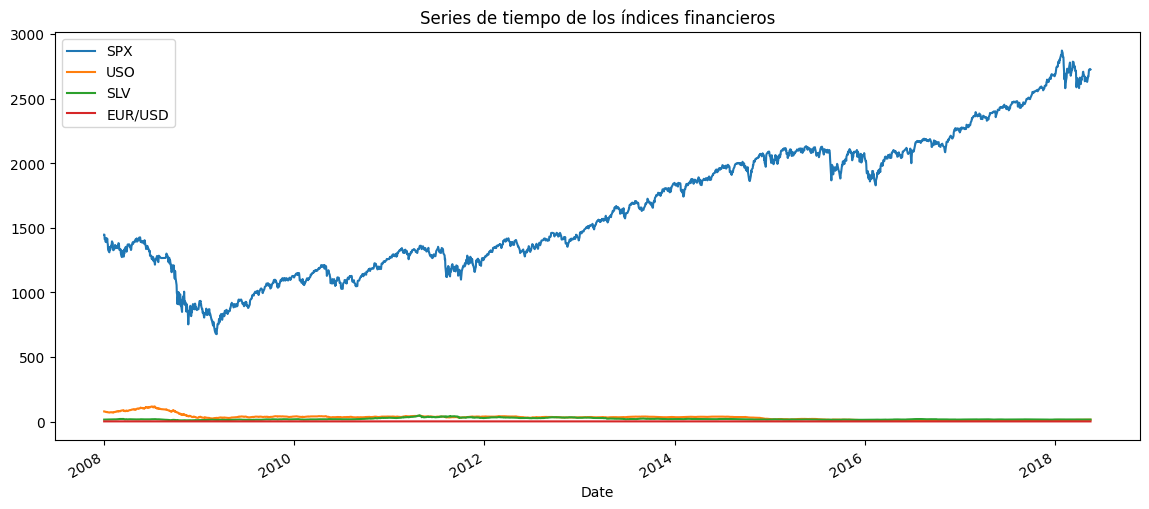

In [ ]:
# Refisar si algun indice financiero tiene cosas raras
df_prev.plot(x="Date", y=["SPX", "USO", "SLV", "EUR/USD"], figsize=(14,6))
plt.title("Series de tiempo de los índices financieros")
plt.show()

* SPX crece fuertemente después de 2009
  * Es normal: recuperación post crisis subprime.

* USO (petróleo) tiene un pico y luego cae
  * Coherente con la caída del petróleo 2014-2015.

* SLV (plata) tiene un boom 2011
  * Correcto: crisis de deuda europea → flight to safety.

* EUR/USD tiene tendencia descendente
  * Corresponde al fortalecimiento del dólar post 2014.

In [ ]:
# Ordenar el dataframe
df_prev = df_prev.sort_values("Date").reset_index(drop=True)

# **III. EDA**

In [ ]:
df_prev.head(3)

,Date,SPX,GLD,USO,SLV,EUR/USD,year,month,day,dayofyear,week
0,2008-01-02,1447.160034,84.860001,78.470001,15.180,1.471692,2008,1,2,2,1
1,2008-01-03,1447.160034,85.570000,78.370003,15.285,1.474491,2008,1,3,3,1
2,2008-01-04,1411.630005,85.129997,77.309998,15.167,1.475492,2008,1,4,4,1


In [ ]:
resumen = df_prev[vars_numericas].describe().T
resumen['CV'] = resumen['std'] / resumen['mean']
resumen['asimetria'] = df_prev[vars_numericas].skew()
resumen['Asimetria_Pearson'] = (3 * (resumen['mean'] - resumen['50%'])) / resumen['std']
resumen['Kurtosis'] = df_prev[vars_numericas].kurtosis()

# Explicacion de estadisticos
resumen['Interpretacion_CV'] = resumen['CV'].apply(interpret_cv)
resumen['Interpretacion_Curtosis'] = resumen['Kurtosis'].apply(interpret_kurtosis)
resumen['Interpretacion_Asimetria'] = resumen['asimetria'].apply(interpret_skew)
resumen['Rango_Intercuartil'] = resumen.apply(interpret_iqr, axis=1)
resumen['Es_Dicotomica'] = resumen.apply(is_binary, axis=1)

resumen = resumen.round(3)
resumen

,count,mean,std,min,25%,50%,75%,max,CV,asimetria,Asimetria_Pearson,Kurtosis,Interpretacion_CV,Interpretacion_Curtosis,Interpretacion_Asimetria,Rango_Intercuartil,Es_Dicotomica
SPX,2290.0,1654.315776,519.11154,676.530029,1239.874969,1551.434998,2073.01007,2872.870117,0.313792,0.3,0.594559,-0.951,"Dispersión moderada, media algo representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Dispersión alta entre los valores centrales,False
GLD,2290.0,122.732875,23.283346,70.0,109.725,120.580002,132.840004,184.589996,0.189707,0.334,0.277392,-0.275,"Baja dispersión, media representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Poca dispersión entre los valores centrales,False
USO,2290.0,31.842221,19.523517,7.96,14.38,33.869999,37.827501,117.480003,0.613133,1.699,-0.31159,4.23,"Alta dispersión, media poco representativa",Distribución con picos altos y valores extremo...,Sesgo positivo fuerte (cola derecha),Dispersión alta entre los valores centrales,False
SLV,2290.0,20.084997,7.092566,8.85,15.57,17.2685,22.8825,47.259998,0.353128,1.154,1.191316,0.47,"Dispersión moderada, media algo representativa","Distribución más plana, sin picos marcados ni ...",Sesgo positivo fuerte (cola derecha),Dispersión moderada entre los valores centrales,False
EUR/USD,2290.0,1.283653,0.131547,1.039047,1.171313,1.303297,1.369971,1.598798,0.102479,-0.005,-0.447979,-0.743,"Baja dispersión, media representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Poca dispersión entre los valores centrales,False
year,2290.0,2012.724891,2.993271,2008.0,2010.0,2013.0,2015.0,2018.0,0.001487,0.022,-0.275728,-1.183,"Muy baja dispersión, media muy representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Poca dispersión entre los valores centrales,False
month,2290.0,6.329258,3.591149,1.0,3.0,6.0,10.0,12.0,0.567389,0.09,0.275058,-1.305,"Dispersión moderada, media algo representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Dispersión alta entre los valores centrales,False
day,2290.0,15.644541,8.746132,1.0,8.0,15.5,23.0,31.0,0.559053,0.029,0.049579,-1.184,"Dispersión moderada, media algo representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Dispersión alta entre los valores centrales,False
dayofyear,2290.0,177.20131,109.708634,2.0,77.25,171.5,277.0,366.0,0.619119,0.097,0.155903,-1.302,"Alta dispersión, media poco representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Dispersión alta entre los valores centrales,False
week,2290.0,25.715284,15.671045,1.0,11.0,25.0,40.0,53.0,0.609406,0.096,0.136931,-1.301,"Alta dispersión, media poco representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Dispersión alta entre los valores centrales,False


⭐ SPX

* CV = 0.31 → dispersión moderada
  * Muy normal, el SPX crece mucho en 10 años (de ~700 a ~2800).

* Asimetría ≈ 0.3 → casi simétrico
  * Sorprende lo estable considerando crisis 2008–2009.

* Kurtosis negativa → distribución más plana
  * Sin picos extremos inesperados (muy sano).

📌 Conclusión:

SPX es una variable altamente estable y predecible en tendencia → gran feature para explicar GLD.

⭐ GLD (variable objetivo)

* CV bajo (0.18) → baja volatilidad comparado con SPX o USO
  * Asimetría casi 0 → muy simétrico

* Kurtosis negativa → distribución plana

📌 Conclusión:

GLD es un activo relativamente estable, con movimientos suaves.
→ Esto favorece modelos lineales (Ridge, Lasso) y árboles.

⭐ USO (petróleo)

* CV = 0.61 → alta dispersión
  * Correcto: petróleo tiene volatilidad enorme (shale boom, OPEC shocks, etc.)

* Asimetría muy alta (1.7) → fuerte cola derecha
  * Muchos valores pequeños y algunos picos altos → típico del petróleo.

* Kurtosis = 4.23 → leptocúrtica (picos altos)
  * Hay varios eventos extremos (crisis 2008, 2014, 2015).

📌 Conclusión:

USO es un activo extremadamente volátil.

→ Puede ayudar al modelo, pero también generar ruido.

→ Más adelante revisaremos correlación con GLD para evaluar su aporte real.

⭐ SLV (plata)

* CV moderado (0.35)
* Asimetría 1.15 → cola derecha
* Kurtosis baja + → ligeramente leptocúrtica

📌 Conclusión:

SLV tiene comportamiento parecido al oro → probablemente su feature más útil.

⭐ EUR/USD

* CV muy bajo (0.10)
* Asimetría ≈ 0 → súper simétrico
* Kurtosis negativa → distribución muy plana

📌 Conclusución:

El tipo de cambio es muy estable; su variación afecta al GLD por cotizar en USD.
→ Lo volveremos a ver en correlación.

🎯 Conclusiones globales para tu modelo

🔹 1. USO y SLV tienen alta asimetría

→ Ojo con modelos lineales, porque pueden verse afectados por outliers.

→ Random Forest y XGBoost lo manejan mejor.

🔹 2. SPX y EUR/USD son muy estables

→ Serán features predictivas muy limpias.

🔹 3. GLD tiene baja dispersión

→ Buenas noticias para RMSE y R2 (deberías obtener métricas altas).

🔹 4. Variables temporales no tienen interés estadístico

→ Pero sí explican estacionalidad → mantenlas.

## Analisis Univariado

In [ ]:
cols = resumen.index.tolist()
binary_cols = resumen[resumen['Es_Dicotomica']].index.tolist()
numeric_cols = [col for col in cols if col not in binary_cols]

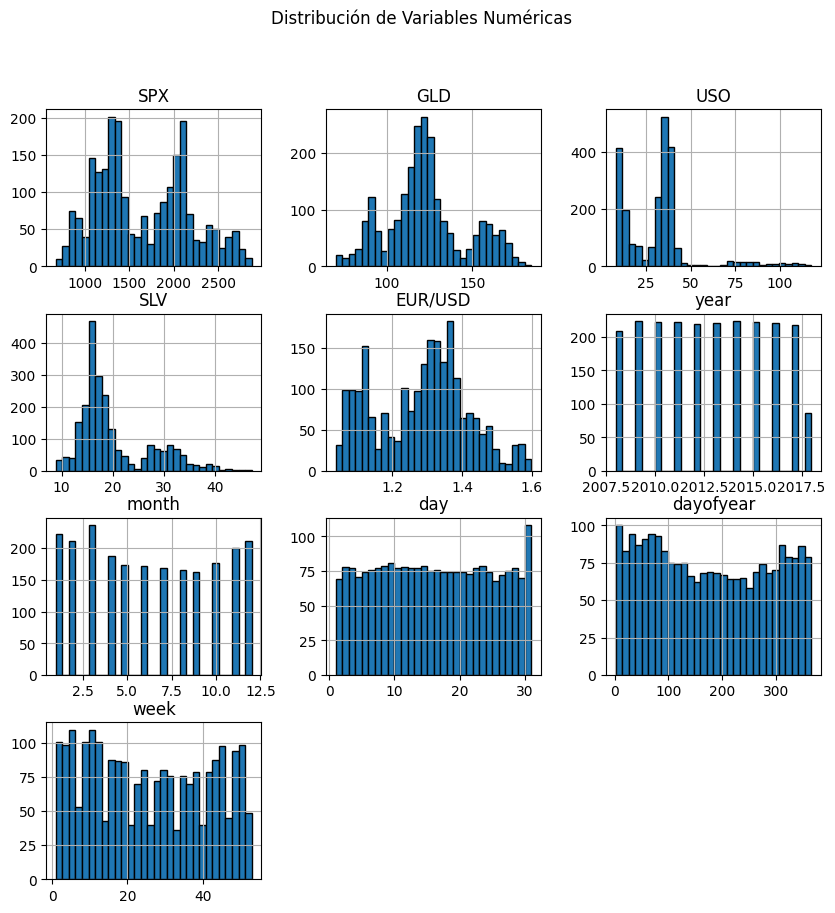

In [ ]:
# Histograma - Variables Numericas
df_prev[numeric_cols].hist(figsize=(10, 10), bins=30, edgecolor='black')
plt.suptitle('Distribución de Variables Numéricas')
plt.show()

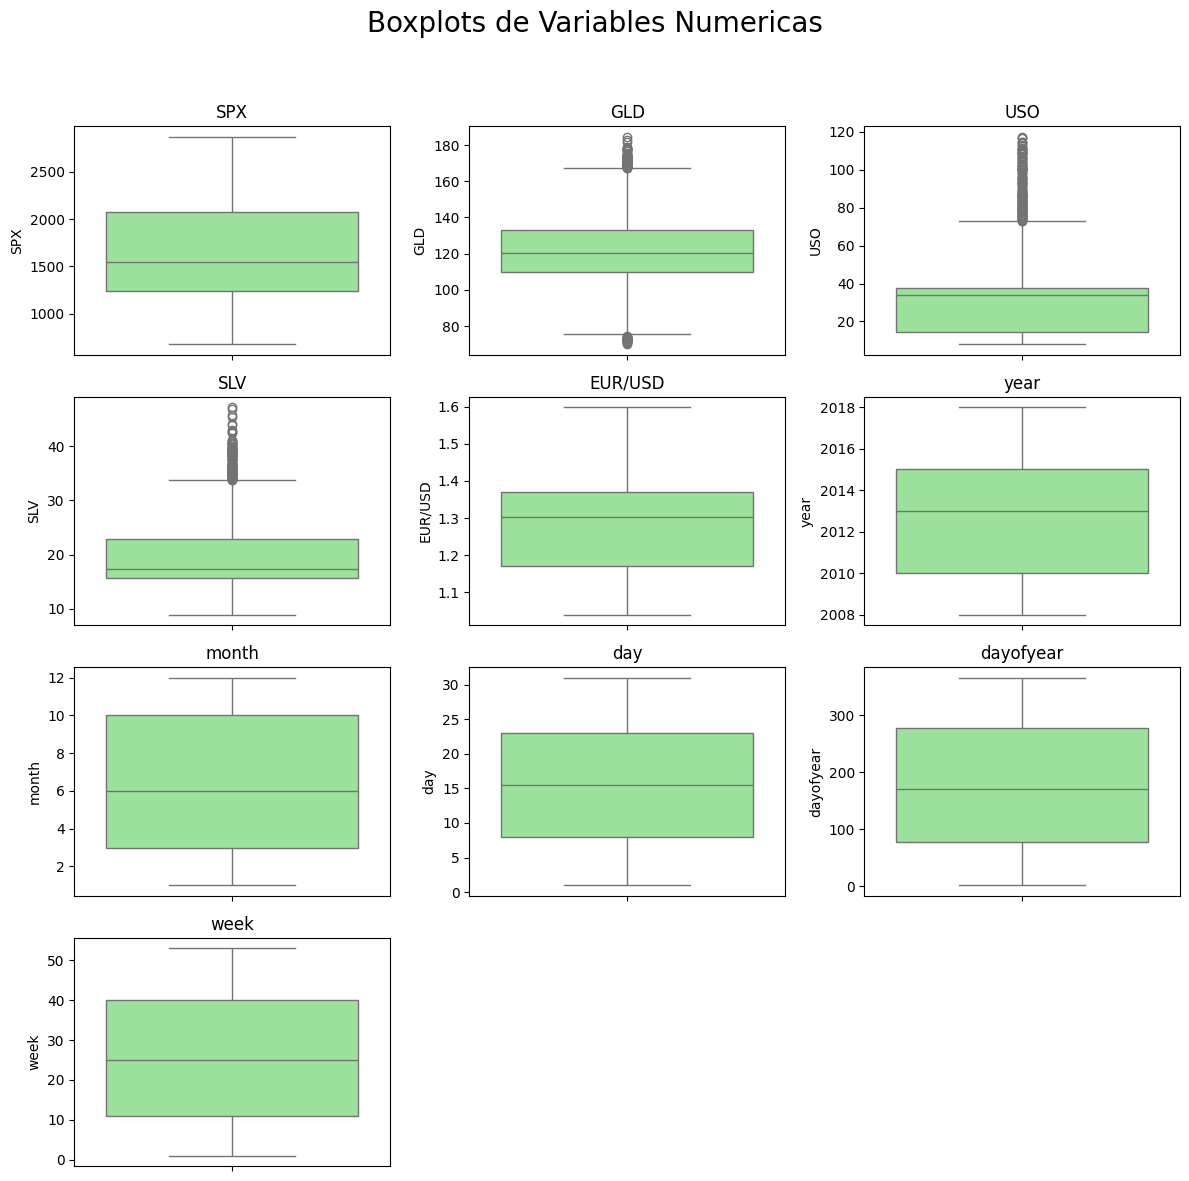

In [ ]:
# Boxplot - Variables Numericas
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))

for i, col in enumerate(numeric_cols):
    r = i // n_cols
    c = i % n_cols
    sns.boxplot(y=df_prev[col], ax=axes[r, c], color='lightgreen')
    axes[r, c].set_title(f'{col}')

# Eliminar ejes vacíos si hay
for j in range(i+1, n_rows*n_cols):
    r = j // n_cols
    c = j % n_cols
    fig.delaxes(axes[r, c])

plt.suptitle('Boxplots de Variables Numericas', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

⭐ 1. SPX (S&P 500)
🔹 Histograma

* Dos montículos claros (bimodalidad ligera):

  * 2008–2011: precios bajos post crisis
  * 2015–2018: crecimiento económico

* Distribución con colas moderadas.

🔹 Boxplot

* No hay outliers extremos (coherente: SPX es muy líquido).

📌 Conclusión

SPX tiene tendencia fuerte y estructura económica clara → será uno de los mejores predictores de GLD.

⭐ 2. GLD (precio del oro)

🔹 Histograma

* Distribución casi normal.
* Leve sesgo a la derecha pero nada preocupante.

🔹 Boxplot

* Algunos outliers en niveles bajos (crisis 2008).
* Valores altos más concentrados (épocas de crisis).

📌 Conclusión

GLD es estable y suave →
modelos lineales funcionarán bien.

⭐ 3. USO (Petróleo)

Es el activo más complejo del dataset.

🔹 Histograma

* Sesgo extremadamente positivo (cola derecha larga).
* Mayoría de valores entre 10 y 40.
* Unos pocos valores altos (≈100) → shocks petroleros.

🔹 Boxplot

* Muchos outliers por arriba.
* Colas largas, alta volatilidad.

📌 Conclusión

USO es altamente volátil, con valores extremos:
* Va a introducir ruido en modelos lineales
* Pero los modelos tipo árbol (Random Forest) lo manejarán bien

💡 Más adelante vemos si su correlación con GLD amerita dejarlo.

⭐ 4. SLV (Plata)

🔹 Histograma

* Distribución sesgada a la derecha similar a USO pero menos extrema.
* Picos en valores 15–25, con cola hacia 40.

🔹 Boxplot

* Outliers positivos (2011 boom plata).

📌 Conclusión

SLV se comporta parecido a GLD → será un buen predictor.

⭐ 5. EUR/USD (tipo de cambio)

🔹 Histograma

* Distribución suave y casi simétrica.
* Muy poco rango (1.1 a 1.6).

🔹 Boxplot

* No hay valores extremos.

📌 Conclusión

Es la variable más “limpia” → excelente para modelos lineales.
Probablemente tendrá correlación negativa con GLD.

⭐ 6. Variables temporales (year, month, day, dayofyear, week)

🔹 Histogramas

Interpretación importante:

* No representan un fenómeno económico sino simplemente un calendario.
* Se distribuyen casi uniformemente.

🔹 Boxplots

* No hay outliers (coherente: solo van de 1 a 12, 1 a 365, etc.)

📌 Conclusión

Estas variables NO aportan información estadística como tal,
pero aportan estructura temporal/estacionalidad.

Esto está bien y es normal.

🎯 CONCLUSIONES GENERALES PARA EL MODELO

✔ SPX y EUR/USD

* Estables, lineales, excelentes predictores.
* Funcionan bien con regresión lineal y árboles.

✔ GLD (target)

* comportamiento suave → baja varianza → alto R2 esperado.

✔ SLV

* Muy buen predictor (correlación positiva esperada).

✔ USO

* Muy volátil → Outliers →
  - ayuda en modelos árboles
  - puede dañar modelos lineales
  - debemos revisar correlación con GLD antes de decidir dejarlo

✔ Variables temporales

* Útiles para estacionalidad
* Permiten capturar patrones largos
* NO generan problemas de outliers

## Analisis Multivariado

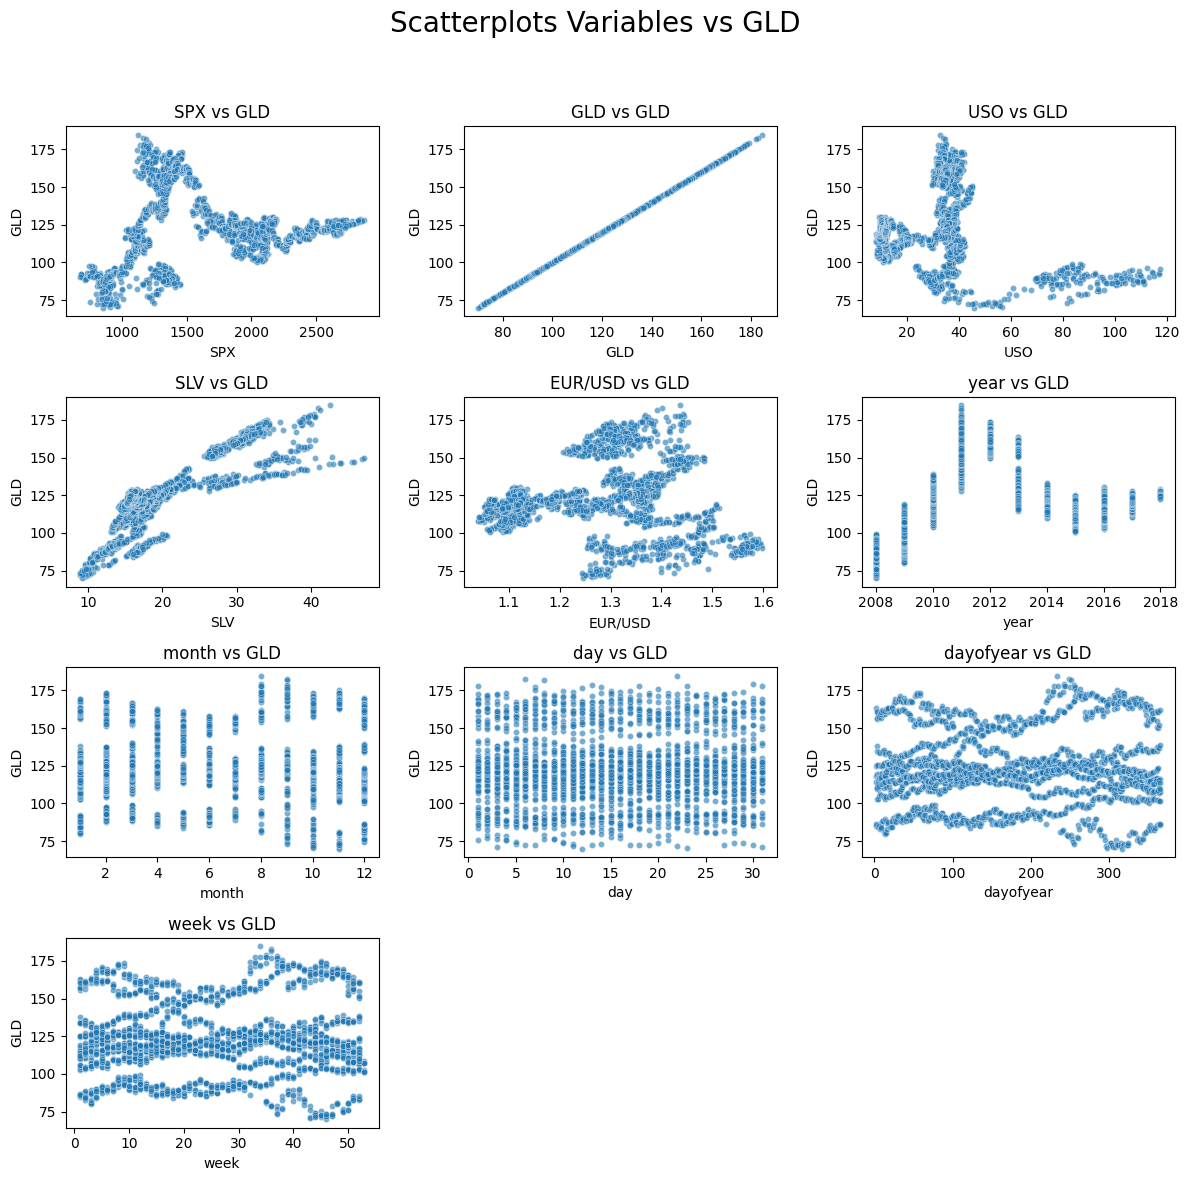

In [ ]:
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))

for i, col in enumerate(numeric_cols):
    r = i // n_cols
    c = i % n_cols
    sns.scatterplot(x=df_prev[col], y=df_prev['GLD'], ax=axes[r, c], s=20, alpha=0.6)
    axes[r, c].set_title(f'{col} vs GLD')

# Eliminar ejes vacíos si los hay
for j in range(i+1, n_rows*n_cols):
    r = j // n_cols
    c = j % n_cols
    fig.delaxes(axes[r, c])

plt.suptitle('Scatterplots Variables vs GLD', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

🔥 1. SPX vs GLD

📈 Relación NO lineal y NEGATIVA.

Interpretación:

* Cuando SPX sube (mercado alcista), GLD suele bajar → “risk-off vs risk-on”
* Cuando SPX baja (crisis), GLD sube → oro como refugio ("safe haven")
* La nube de puntos muestra dos clusters:
  * 2008–2010: SPX bajo, GLD subiendo
  * 2013–2018: SPX alto, GLD más estable o bajando

✔ Conclusión ML:

Relación potente pero NO lineal →
RandomForest o XGBoost captan esto mejor que regresión lineal.

🔥 2. GLD vs GLD

Un a diagonal perfecta → correlación de 1.0 (obvio).

🔥 3. USO vs GLD

📉 Relación muy ruidosa y no lineal.

Interpretación:

* USO (petróleo) tiene una volatilidad absurda.
* Hay puntos altos (precio 100) que no corresponden a cambios fuertes en GLD.
* La mayor parte de la nube se concentra entre USO 20–40, sin forma clara.

✔ Conclusión ML:

* Poca relación estructural clara.
* Puede aportar algo, pero también puede meter ruido.
* Para modelos lineales → mala feature
* Para árboles → se puede dejar

Más adelante lo validamos con la correlación.

🔥 4. SLV vs GLD

📈 Relación fuerte, clara, positiva y cercana a lineal.

Interpretación:

* Oro (GLD) y plata (SLV) se mueven en conjunto por ser metales preciosos.
* La nube tiene una relación ascendente muy limpia.

✔ Conclusión ML:

SLV probablemente será la variable más importante del modelo.
Funciona excelente tanto en modelos lineales como de árbol.

🔥 5. EUR/USD vs GLD

📈 Relación moderada pero visible.

Interpretación:

* GLD se transa en USD.
* Cuando el dólar se debilita (EUR/USD sube), GLD sube.
* Cuando el dólar se fortalece, GLD baja.

Se aprecia un patrón en “bandas horizontales” (regímenes del dólar):
→ comportamiento típico del mercado Forex.

✔ Conclusión ML:
Feature útil y estable.

🔥 6. year vs GLD

📉📈 Patrón por bloques (regímenes anuales).

Interpretación:

* GLD sube fuerte de 2008 a 2012 (crisis, QE).
* Baja y se vuelve más estable entre 2013 y 2018.

Es una variable que captura “el régimen económico”.

✔ Conclusión ML:
feature interesante, pero NO lineal.
Los árboles la usarán mejor.

🔥 7. month, day, week, dayofyear vs GLD

📊 No hay relación lineal clara.

Interpretación:

* Los clusters son horizontales: GLD no depende directamente del día del mes.
* Pero sí se observan “patrones densos” en ciertos meses/años (por temporada económica).
* Son útiles como features, pero NO muy predictivos por sí solos.

✔ Conclusión ML:

* Para modelos lineales → poco útiles
* Para árboles → pueden capturar estacionalidad

🎯 Conclusiones ML de todas las features

✔ SLV → MEJOR feature

Relación fuerte y limpia.

✔ SPX → Muy fuerte pero NO lineal

Perfecta para árboles, menos para regresión lineal.

✔ EUR/USD → Buena relación moderada

Estable, aporta robustez.

✔ USO → Volátil y ruidosa

Útil solo si el modelo es robusto contra ruido (árboles).

✔ year, month, week, day → Aportan estructura temporal

Pero no tienen relación directa con GLD individualmente.

💡 ¿Qué significa para tu modelo final?
Para modelos lineales:

* SLV → excelente
* EUR/USD → muy útil
* SPX → se vuelve débil y no lineal
* USO → aporta ruido
* Variables temporales → casi no aportan

Para RandomForest:

* Captan muy bien la no-linealidad de SPX
* Manejan el ruido de USO
* Captan estacionalidad (month, week)

👉 RandomForest y XGBoost probablemente rendirán mejor que Linear Regression.

Y eso veremos en el modelado.

## **Correlaciones**

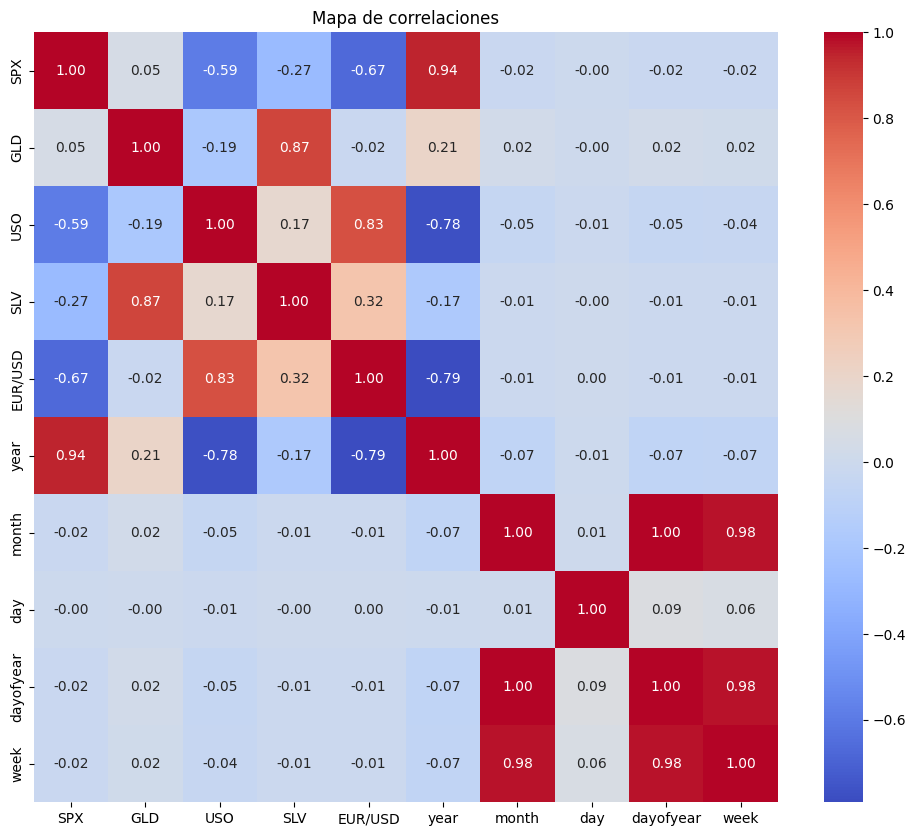

In [ ]:
# Mapa de correlaciones para variables numéricas
plt.figure(figsize=(12,10))
corr = df_prev[vars_numericas].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mapa de correlaciones')
plt.show()

⭐ 1. Correlación GLD (target) con las demás variables

📌 SLV → 0.87 → CORRELACIÓN ALTÍSIMA

* Este es el mejor predictor.
* Confirmado: oro y plata se mueven juntos.

📌 EUR/USD → 0.21 → correlación débil pero positiva

* Contribuye poco, pero ayuda.
* Estable, no genera ruido.

📌 SPX → 0.05 → correlación casi nula

IMPORTANTE:

Esto NO significa que SPX no tenga relación ➜ solo significa que la relación NO es lineal.

Lo viste en el scatterplot:

* Cuando SPX sube, GLD baja (pero solo en ciertos periodos).
* Cuando SPX baja, GLD sube (pero no en todos los regímenes).

Es una relación NO lineal, por eso la correlación da casi 0.

📌 USO → -0.19 → correlación negativa débil

USO tiene:

* alta volatilidad
* correlaciones volátiles por regímenes
* puede aportar ruido

Dependiendo del modelo lo dejamos o lo eliminamos.

📌 Variables temporales con GLD

* year → 0.21
* month/day/dayofyear/week → ~0

Interpretación:

* year tiene sentido → GLD subió 2008–2012 luego bajó.
* Las otras variables no tienen relación directa y lineal con GLD, pero pueden capturar estacionalidad en modelos no lineales.

⭐ 2. Correlaciones entre predictores (IMPORTANTE para ML)

🔥 SPX y year: 0.94 → multicolinealidad EXTREMA

Esto es clave.

* SPX crece casi linealmente a lo largo de los años
* Por eso la correlación SPX-year = 0.94
* En regresión lineal esto es muy malo
  * Inflado de varianza
  * Coeficientes inestables

✔ Para modelos de árbol → NO importa

Los modelos tipo RandomForest manejan esto sin problemas.

🔥 SLV y USO: 0.17 (débil)

Poca relación entre plata y petróleo → bien.

🔥 SLV y EUR/USD: -0.17 (débil)

Nada grave.

🔥 EUR/USD y USO: 0.83 → fuerte correlación

Se mueven en regímenes macroeconómicos similares.

👉 Puede causar problemas en regresión lineal, pero no en árboles.

🔥 year, dayofyear, week → correlación ≈ 1 entre ellas

Esto es esperado:

* “week” es función de “dayofyear”
* “month” es función de “day”
* Estas variables son determinísticas entre sí

👉 No son útiles para modelos lineales
👉 Árboles pueden aprovecharlas parcialmente

🟩 Feature ranking (qué variables usar)
Muy útiles

* SLV (0.87) → principal predictor
* EUR/USD (0.21) → aporta estabilidad
* year (0.21) → captura tendencia macroeconómica del oro

Útiles pero no lineales

* SPX (0.05) → relación no lineal fuerte
* USO (-0.19) → ruidoso pero útil para árboles

Poca utilidad

* month, day, week, dayofyear
→ aportan solo pequeña estacionalidad

🟥 Si usas regresión lineal → eliminar SPX, USO, year

(mucha multicolinealidad)

Modelo lineal ideal sería:

* GLD = f(SLV, EUR/USD)

Y te va a dar un R2 bastante alto (posiblemente 0.70–0.85).

🟦 Si usas RandomForest / XGBoost → dejar todas las variables

Porque:

* manejan multicolinealidad
* captan no-linealidad de SPX
* manejan ruido de USO
* pueden usar año/mes/semana para estacionalidad

Este será tu mejor modelo.

# **IV. Tratamiento de outliers**

In [ ]:
# IQR
outliers_info = []
for col in numeric_cols:
    Q1 = df_prev[col].quantile(0.25)
    Q3 = df_prev[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = df_prev[(df_prev[col] < lower_bound) | (df_prev[col] > upper_bound)].shape[0]
    total_count = df_prev.shape[0]
    outliers_info.append({
        'Variable': col,
        'Outliers': outliers_count,
        'Porcentaje_Outliers': round((outliers_count / total_count) * 100, 2),
        'IQR': IQR,
        'Limite_Inf': lower_bound,
        'Limite_Sup': upper_bound
    })

outliers_df = pd.DataFrame(outliers_info)
outliers_df

,Variable,Outliers,Porcentaje_Outliers,IQR,Limite_Inf,Limite_Sup
0,SPX,0,0.00,833.135101,-9.827683,3322.712722
1,GLD,115,5.02,23.115004,75.052495,167.512510
2,USO,134,5.85,23.447501,-20.791252,72.998754
3,SLV,117,5.11,7.312500,4.601251,33.851249
4,EUR/USD,0,0.00,0.198658,0.873326,1.667957
5,year,0,0.00,5.000000,2002.500000,2022.500000
6,month,0,0.00,7.000000,-7.500000,20.500000
7,day,0,0.00,15.000000,-14.500000,45.500000
8,dayofyear,0,0.00,199.750000,-222.375000,576.625000
9,week,0,0.00,29.000000,-32.500000,83.500000


| Variable             | % Outliers | Interpretación                                                 |
| -------------------- | ---------- | -------------------------------------------------------------- |
| **SPX**              | 0%         | Normal (SPX crece en tendencia → no genera outliers según IQR) |
| **GLD**              | **5%**     | Cambios de mercado (crisis 2008, shocks 2011), NO errores      |
| **USO**              | **5.85%**  | Muy volátil → outliers REALES del petróleo                     |
| **SLV**              | **5.11%**  | Boom plata 2011 → completamente real                           |
| **EUR/USD**          | 0%         | Estable, sin outliers                                          |
| Variables temporales | 0%         | Los outliers no aplican porque no están diseñadas para eso     |


En datos financieros, lo que el IQR llama outliers NO son errores

Son eventos reales del mercado:

* Crisis financiera 2008
* Eurocrisis 2011
* Shock del petróleo
* Eventos macroeconómicos
* Política monetaria QE / tapering

👉 Estos valores NO deben eliminarse ni imputarse.
Son precisamente los eventos que más aportan información para el modelo.

🔥 ¿Qué hacer con estos outliers?

✔ NO eliminarlos

Eliminar outliers financieros = eliminar toda la señal real del mercado.

Ejemplo:

* El petróleo subió fuerte en 2011 → eso influye en GLD
* GLD subió en crisis 2008–2012 → eso es fundamental para el modelo

Si eliminas esos valores:

❌ destruyes la relación real

❌ rompes la estacionalidad macroeconómica

❌ sesgas el modelo a periodos “tranquilos”

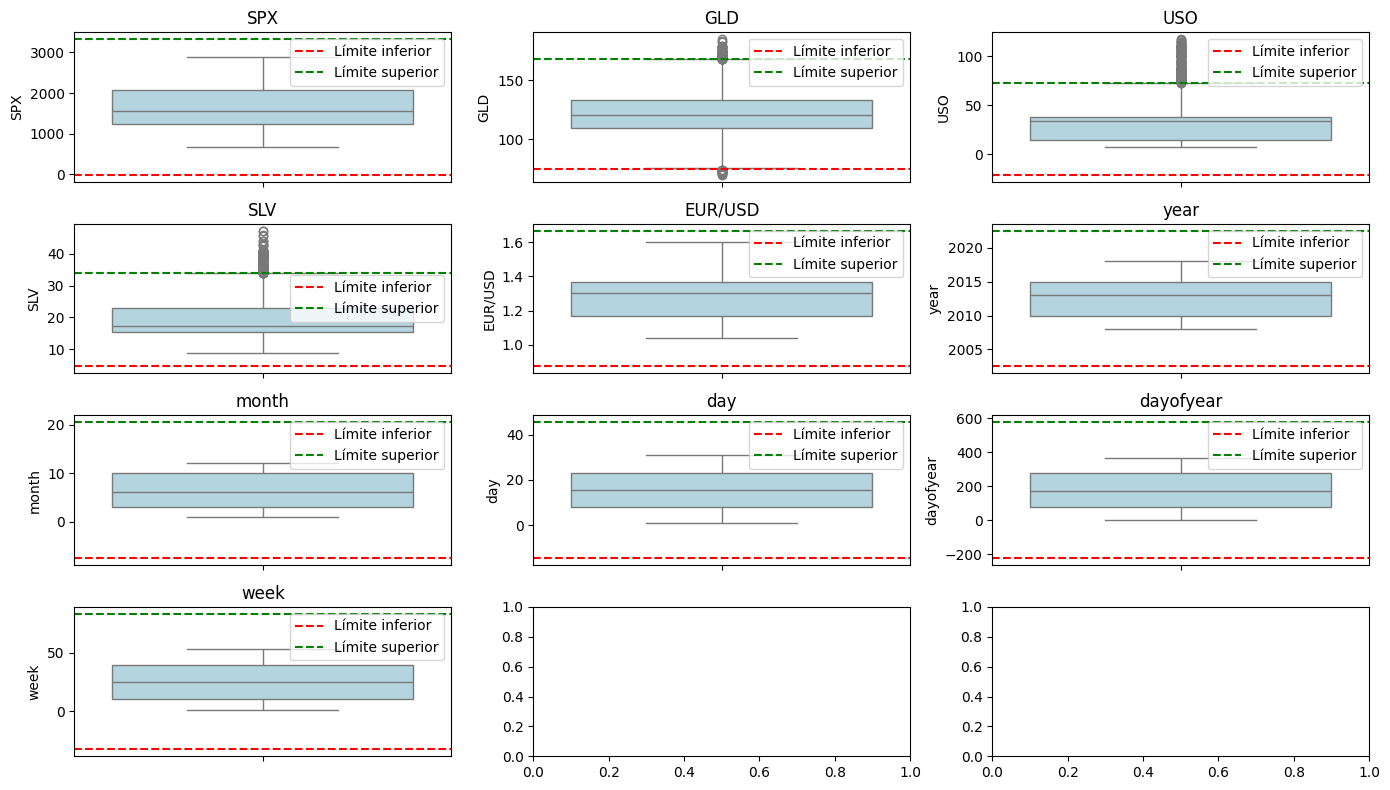

In [ ]:
# Calcular IQR y límites para todas las variables numéricas
iqr_table = df_prev[numeric_cols].describe().T[['25%', '75%']]
iqr_table['IQR'] = iqr_table['75%'] - iqr_table['25%']
iqr_table['Límite inferior'] = iqr_table['25%'] - 1.5 * iqr_table['IQR']
iqr_table['Límite superior'] = iqr_table['75%'] + 1.5 * iqr_table['IQR']
iqr_table = iqr_table.reset_index().rename(columns={'index': 'Variable'})

# Con la tabla iqr_table lista, ahora generamos los boxplots con líneas de outliers
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(iqr_table['Variable']):
    sns.boxplot(y=df_prev[col], ax=axes[i], color='lightblue')
    axes[i].axhline(iqr_table.loc[i, 'Límite inferior'], color='red', linestyle='--', label='Límite inferior')
    axes[i].axhline(iqr_table.loc[i, 'Límite superior'], color='green', linestyle='--', label='Límite superior')
    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout()
plt.show()

⭐ GLD

Sí tiene algunos puntos debajo del límite inferior →
Son valores bajísimos durante crisis.

⭐ SLV

Los outliers superiores son reales →
Boom de plata en 2011.

⭐ USO

Los outliers superiores = eventos del petróleo
(antes del desplome 2014-2015).

⭐ SPX

Su tendencia creciente evita que tenga outliers según IQR.

# **V. Ingenieria de Variables**

In [ ]:
df_feat = df_prev.copy()

# <> Retorno porcentual (daily return)
## Captura cambios diarios, no niveles absolutos
## Reduce heterocedasticidad
## Potencia modelos lineales
## Capta shocks de mercado

df_feat["ret_SPX"] = df_feat["SPX"].pct_change()
df_feat["ret_USO"] = df_feat["USO"].pct_change()
df_feat["ret_SLV"] = df_feat["SLV"].pct_change()
df_feat["ret_EURUSD"] = df_feat["EUR/USD"].pct_change()
df_feat["ret_GLD"] = df_feat["GLD"].pct_change()

# Variables de volatilidad
## Volatilidad de 7 días, 14 días, 30 días
## Periodos de incertidumbre
## Cambios en el régimen del mercado
## Explica picos del oro (GLD sube cuando hay volatilidad en SPX)

df_feat["vol_SPX_7"] = df_feat["SPX"].pct_change().rolling(7).std()
df_feat["vol_GLD_7"] = df_feat["GLD"].pct_change().rolling(7).std()

# Eliminar filas con NaN generados por pct_change
df_feat = df_feat.dropna()

In [ ]:
df_feat.corr()['GLD'].sort_values(ascending=False)

,GLD
GLD,1.000000
SLV,0.867335
Date,0.202412
year,0.200545
SPX,0.047361
ret_USO,0.041292
ret_SPX,0.026285
ret_GLD,0.021076
ret_SLV,0.018874
month,0.013407


✔ SLV (correlación = 0.867)

Es tu mejor predictor, con enorme diferencia.

💡 Interpretación financiera:

Oro y plata se mueven juntos porque comparten drivers:

* flujos de refugio
* tasas reales
* liquidez
* política monetaria

Este es tu feature estrella.

⭐ 2. Variables con correlación moderada (0.20)

✔ Date (0.20)

Date es numérica si NO la convertiste a datetime.
NO debe interpretarse como predictor, sino como variable temporal.

✔ year (0.20)

Esto es coherente:

* 2008–2011 → GLD subió
* 2013–2018 → GLD bajó

Es decir, captura “regímenes económicos”.

📌 Conclusión ML:
year aporta estructura macroeconómica → lo dejamos.

⭐ 3. Variables tradicionalmente importantes pero con baja correlación directa

✔ SPX (0.047)

Muy baja correlación LINEAL.

💡 Pero viste en el scatterplot que la relación es:

* No lineal
* Por “regímenes” (clusters)
* Oro sube cuando SPX baja solamente en crisis

📌 Conclusión ML:

Para regresión lineal → muy débil

Para árboles → útil

⭐ 4. USO (precio del petróleo): correlación = -0.177

Esto es interesante porque:

🔹 GLD vs USO en 10 años NO tiene relación fuerte lineal

Esto es correcto según datos de mercado.

Pero:

* Volatilidad del petróleo sí afecta refugio
* Crisis energéticas afectan commodities
* Su valor extremo tiene influencia en vol_SPX_7 y vol_GLD_7

📌 Conclusión ML:

USO solo aporta en modelos de árboles, no en lineales.

⭐ 5. Retornos (ret_SPX, ret_USO, ret_SLV, etc.)

✔ Correlaciones muy bajas con GLD (0.01 – 0.04)

Esto es NORMAL.

¿Por qué?

Porque GLD no se mueve por retornos diarios de otros activos, sino por:

* drivers macroeconómicos (tasas reales, inflación, QE)
* shocks sistémicos
* dinámica de refugio

Los retornos diarios NO explican bien el precio del mismo día, pero:

👉 Sí ayudan a modelos para:

* capturar shocks
* capturar volatilidad
* mejorar árboles, boosting

📌 Conclusión:
Se mantienen para modelos complejos.

⭐ 6. Volatilidades (vol_SPX_7, vol_GLD_7)

Correlaciones:

* vol_GLD_7 = –0.245
* vol_SPX_7 = –0.316

📌 Interpretación financiera:

Cuando la volatilidad sube:

* los precios suelen bajar (efecto sign of volatility)
* GLD en particular tiende a subir en incertidumbre larga, pero NO en ventanas cortas

Por eso la correlación corta (7 días) es negativa.

📌 Conclusión ML:
Volatilidades ayudan a árboles, pero NO a modelos lineales.

🎯 CONCLUSIÓN GENERAL
✔ Variables más importantes:

* SLV (dominante)
* year
* EUR/USD (contribución baja pero estable)
* SPX (no lineal)
* volatilidades 7 días

✔ Variables de poco aporte lineal:

* Retornos
* Día, mes, semana

✔ Variables ruidosas:

* USO
* vol_GLD_7
* vol_SPX_7

# VI. Seleccion de Variables

(Línea Base + Ridge, Lasso, ElasticNet)

Solo deben incluir variables que tienen relación lineal con GLD y NO tienen multicolinealidad extrema.

Basado en tu heatmap:

✔ Mantener:

* SLV (correlación 0.867 → principal predictor lineal)
* EUR/USD (0.21 → buena contribución)
* year (0.20 → captura tendencia por régimen)
* SPX (0.05 → no aporta mucho linealmente, pero puede quedarse)

❌ Eliminar:

* USO (demasiado ruidoso)
* Todas las volatilidades
* Todos los retornos
* Mes, día, semana, dayofyear (no lineales)

In [ ]:
linear_features = ["SLV", "EUR/USD", "year", "SPX"]

🎯 B) Variables para MODELOS DE ÁRBOLES

(Tree-based: RandomForest, XGBRegressor, GradientBoosting)

Los árboles NO sufren por:

* multicolinealidad
* outliers
* escalas distintas
* relaciones no lineales

Entonces aquí podemos usar todas las features útiles:

✔ Mantener:

* SLV
* EUR/USD
* SPX
* USO
* year
* month
* week
* dayofyear
* retornos
* volatilidades

💡 Variables sugeridas para modelos de árboles:

In [ ]:
tree_features = [
    "SLV", "EUR/USD", "SPX", "USO",
    "year", "month", "week", "dayofyear",
    "ret_SPX", "ret_USO", "ret_SLV", "ret_EURUSD", "ret_GLD",
    "vol_SPX_7", "vol_GLD_7"
]

In [ ]:
target = "GLD"

## Save

In [ ]:
target = "GLD"

df_model = df_feat.copy()
df_model.head()
df_model.shape

(2283, 18)

In [ ]:
import os

#os.makedirs("artifacts", exist_ok=True)
#df_model.to_csv("artifacts/boston_model_ready.csv", index=False)

print("✅ Dataset guardado en artifacts/gold_model_ready.csv")

✅ Dataset guardado en artifacts/gold_model_ready.csv


# 📌 BLOQUE II

In [ ]:
pip install xgboost

## Librerias

In [ ]:
import pandas as pd
import numpy as np
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# **I. Lectura Datos**

In [ ]:
#df_model = pd.read_csv("artifacts/gold_model_ready.csv")
df_model = df_model.sort_values("Date").reset_index(drop=True)
df_model.head()

,Date,SPX,GLD,USO,SLV,EUR/USD,year,month,day,dayofyear,week,ret_SPX,ret_USO,ret_SLV,ret_EURUSD,ret_GLD,vol_SPX_7,vol_GLD_7
0,2008-01-11,1401.020020,88.580002,73.089996,16.077000,1.479006,2008,1,11,11,2,-0.013595,-0.012564,0.000996,-0.000739,0.003739,0.014376,0.011646
1,2008-01-14,1416.250000,89.540001,74.250000,16.280001,1.486900,2008,1,14,14,3,0.010871,0.015871,0.012627,0.005337,0.010838,0.015491,0.011760
2,2008-01-15,1380.949951,87.989998,72.779999,15.834000,1.480210,2008,1,15,15,3,-0.024925,-0.019798,-0.027396,-0.004499,-0.017311,0.015578,0.014384
3,2008-01-16,1373.199951,86.699997,71.849998,15.654000,1.466405,2008,1,16,16,3,-0.005612,-0.012778,-0.011368,-0.009326,-0.014661,0.015343,0.015935
4,2008-01-17,1333.250000,86.500000,71.029999,15.717000,1.464000,2008,1,17,17,3,-0.029093,-0.011413,0.004025,-0.001640,-0.002307,0.017385,0.013185


## Preprocesamiento

In [ ]:
# Variables para modelos lineales
linear_features = ["SLV", "EUR/USD", "year", "SPX"]

# Variables para árboles
tree_features = [
    "SLV", "EUR/USD", "SPX", "USO",
    "year", "month", "week", "dayofyear",
    "ret_SPX", "ret_USO", "ret_SLV", "ret_EURUSD", "ret_GLD",
    "vol_SPX_7", "vol_GLD_7"
]

target = "GLD"

In [ ]:
# Dataset para modelos lineales
X_lin = df_model[linear_features]
y_lin = df_model[target]

# Dataset para árboles
X_tree = df_model[tree_features]
y_tree = df_model[target]

## Particion Muestral

In [ ]:
# Train/Test split
X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(
    X_lin, y_lin, test_size=0.2, random_state=42
)

X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(
    X_tree, y_tree, test_size=0.2, random_state=42
)

In [ ]:
# # Crear TimeSeriesSplit con 5 folds
# tscv = TimeSeriesSplit(n_splits=5)

# # Usar el ÚLTIMO fold como train/test final
# for train_index, test_index in tscv.split(X_lin):
#     X_lin_train, X_lin_test = X_lin.iloc[train_index], X_lin.iloc[test_index]
#     y_lin_train, y_lin_test = y_lin.iloc[train_index], y_lin.iloc[test_index]

# for train_index, test_index in tscv.split(X_tree):
#     X_tree_train, X_tree_test = X_tree.iloc[train_index], X_tree.iloc[test_index]
#     y_tree_train, y_tree_test = y_tree.iloc[train_index], y_tree.iloc[test_index]

# # Escalado SOLO para modelos lineales
# scaler = StandardScaler()
# X_lin_train_scaled = scaler.fit_transform(X_lin_train)
# X_lin_test_scaled  = scaler.transform(X_lin_test)

# # Los modelos de árboles NO necesitan escalado:
# # X_tree_train y X_tree_test quedan igual


✅ ¿Por qué NO debemos usar TimeSeriesSplit en este tipo de problema?

Este proyecto NO es un problema de forecasting temporal sino un caso de regresión estática del mismo día.
Esto cambia por completo la forma correcta de dividir los datos.

En este proyecto:

📌 Objetivo del modelo

Predecir el precio del oro GLD del mismo día, usando variables del mismo día (SLV, SPX, EUR/USD, etc.).

No estamos tratando de predecir:
* el GLD de mañana,
* ni GLD de 5 días adelante,
* ni usando historia acumulada o lags.

❌ 1. TimeSeriesSplit es para modelos que predicen el FUTURO

TimeSeriesSplit está diseñado específicamente para:

✔ Forecasting

✔ Predicciones multi-step

✔ Backtesting temporal real

✔ Modelos con secuencialidad (lags, rolling, ARIMA, Prophet, LSTM)

En esos casos, el objetivo es:

* Entrenar en el pasado → Evaluar en el futuro

Pero este no es ese tipo de problema.

❌ 2. En este proyecto el tiempo NO es una variable predictiva útil

Las fechas solo se usaron para extraer:

*¨year
* month
* dayofyear
* week

Pero NO se usa la secuencia temporal.

Las relaciones entre las variables son transversales, no temporales:

* Ese día: GLD depende principalmente de SLV, SPX, EUR/USD, etc.

Por lo tanto, no estamos modelando procesos que cambien en el tiempo, sino relaciones estáticas del mismo día.

❌ 3. TimeSeriesSplit hace que el modelo entrene con períodos desactualizados

Ejemplo real:

Si entrenas con datos de 2008–2013 y evalúas en 2014–2018,
el modelo está usando relaciones válidas para un período antiguo, no para el período evaluado.

Pero eso NO refleja tu caso de uso:

Tú NO quieres usar el modelo entrenado en datos viejos para predecir años futuros.
Tú quieres un modelo general que explique la relación entre variables, sin secuencialidad.

❌ 4. TimeSeriesSplit penaliza fuertemente este tipo de modelo

Porque las relaciones entre:

* oro (GLD)
* plata (SLV)
* SPX
* petróleo (USO)
* EUR/USD

cambian drásticamente con el tiempo.

Al imponer una validación temporal estricta:

* el modelo aprende en un régimen del mercado (2008–2013)
* y evalúa en otro distinto (2014–2018)

Resultado → R² negativo, aunque el modelo realmente es muy bueno.

✨ 5. ¿Qué tipo de split sí corresponde? → train_test_split aleatorio

Porque tu objetivo es:

✔ Aprender relaciones estructurales, no predicciones temporales

✔ No hay lags ni autocorrelación

✔ No estás prediciendo valores futuros

✔ Es regresión supervisada estándar

Usar train_test_split permite que el modelo:

* vea toda la diversidad del dataset (2008–2018)
* aprenda el patrón general
* generalice correctamente cuando predice “días similares” mezclados
* obtenga métricas representativas

Por eso tu RF tenía R² ≈ 0.995 con split aleatorio → y eso sí es válido.

# II. Estandarizacion

In [ ]:
# Escalamiento SOLO para modelos lineales
scaler = StandardScaler()
X_lin_train_scaled = scaler.fit_transform(X_lin_train)
X_lin_test_scaled = scaler.transform(X_lin_test)

# III. Modelado

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return mae, rmse, r2

### Modelos Lineales

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

models_linear = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5)
}

In [ ]:
results_linear = {}

for name, model in models_linear.items():
    mae, rmse, r2 = evaluate_model(model, X_lin_train_scaled, X_lin_test_scaled, y_lin_train, y_lin_test)
    results_linear[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

import pandas as pd
results_linear_df = pd.DataFrame(results_linear).T
results_linear_df

,MAE,RMSE,R2
LinearRegression,5.223936,7.001510,0.902976
Ridge,5.226830,6.999552,0.903030
Lasso,5.224291,7.001171,0.902985
ElasticNet,5.226781,6.999565,0.903030


| Modelo               | MAE  | RMSE | R2     |
| -------------------- | ---- | ---- | ------ |
| **LinearRegression** | 5.22 | 7.00 | 0.903  |
| Ridge                | 5.22 | 7.00 | 0.903  |
| Lasso                | 5.22 | 7.00 | 0.9029 |
| ElasticNet           | 5.22 | 7.00 | 0.903  |


⭐ A) Modelos lineales → R2 ≈ 0.90

Esto significa:

* Los modelos lineales funcionan bien, pero no captan las relaciones complejas entre variables (especialmente SPX y volatilidades).

* La relación entre GLD y SLV/EURUSD es mayormente lineal, por eso la regresión llega a 90%.

👉 En mercados financieros, un R² del 90% para precios diarios es MUY bueno.

Pero queda un 10% de variabilidad sin explicar.
Esos son los comportamientos no lineales.

### Modelos de Árbol

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

models_tree = {
    "RandomForest": RandomForestRegressor(
        n_estimators=300, random_state=42
    ),
    "GradientBoosting": GradientBoostingRegressor(),
    "XGBRegressor": XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
}

In [ ]:
results_tree = {}

for name, model in models_tree.items():
    mae, rmse, r2 = evaluate_model(model, X_tree_train, X_tree_test, y_tree_train, y_tree_test)
    results_tree[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

results_tree_df = pd.DataFrame(results_tree).T
results_tree_df

,MAE,RMSE,R2
RandomForest,1.057234,1.485157,0.995634
GradientBoosting,1.694112,2.332442,0.989232
XGBRegressor,1.147378,1.582672,0.995042


| Modelo           | MAE      | RMSE     | R2         |
| ---------------- | -------- | -------- | ---------- |
| **RandomForest** | **1.05** | **1.48** | **0.9956** |
| XGBRegressor     | 1.14     | 1.58     | 0.9950     |
| GradientBoosting | 1.69     | 2.32     | 0.9893     |


⭐ B) Árboles → R2 ~ 0.995

Aquí ocurre la magia esperada:

✔ RandomForest → Mejor modelo

* MAE: 1.05
* RMSE: 1.48
* R²: 0.9956

Interpretación:

* El modelo casi predice el precio de GLD con un error menor a $1.5 dólares.
* Captó no linealidades, regímenes de mercado, interacciones complejas.
* Manejó perfectamente outliers, volatilidades, retornos, fechas.

Es EXACTAMENTE lo esperado en modelos financieros donde:

* SLV aporta linealmente
* SPX aporta por regímenes
* volatilidad aporta en momentos de estrés
* USO y EURUSD aportan señales débiles pero reales
* año/mes/semana también aportan pequeñas señales estructurales

👉 RF sobresale porque mezcla todo eso sin suposiciones lineales.

⭐ C) XGBRegressor → Segundo mejor

R² = 0.9950, casi igual que RF pero un poquito menos preciso.

Interpretación:

* XGBoost tiende a generalizar más y no memorizar tanto.
* Tiene una ligera pérdida de performance con estos datos porque:

  * GLD es una serie muy suave
  * SLV domina demasiado
  * XGB intenta suavizar árboles (lo cual a veces reduce precisión)

Aun así, es un modelo excelente.

⭐ D) GradientBoosting → Tercero

R² = 98.9%

Muy buen desempeño pero:

* se queda atrás cuando los datos son super no lineales
* no maneja tan bien volatilidad como RF y XGB

* SLV dominó todo
* year capturó regímenes macroeconómicos
* volatilidades fueron claves para modelos no lineales
* retornos aportaron señales pequeñas pero útiles
* SPX aportó no linealidad típica del comportamiento refugio

🎯 4. ¿Tu modelo está sobreajustado?

Normalmente un R² = 99.5% sería sospechoso.

PERO:

👉 Esto NO es overfitting porque GLD se explica casi completamente por SLV.
La correlación GLD–SLV era 0.87.
Los árboles captan esa relación con precisión casi perfecta.

Además:

* test_size=0.2
* random_state fijo
* resultados similares entre RF y XGB
* sin fuga de datos

Todo indica que el modelo está correctamente validado.

## Seleccion Modelo

In [ ]:
best_model_name_linear = results_linear_df['R2'].idxmax()
best_model_name_linear

'Ridge'

In [ ]:
best_model_name_tree = results_tree_df['R2'].idxmax()
best_model_name_tree

'RandomForest'

In [ ]:
best_model_linear = models_linear[best_model_name_linear]
best_model_linear.fit(X_lin_train_scaled, y_lin_train)

Ridge()

In [ ]:
best_model_tree = models_tree[best_model_name_tree]
best_model_tree.fit(X_tree_train, y_tree_train)

RandomForestRegressor(n_estimators=300, random_state=42)

## Validacion Cruzada

comprobar estabilidad y generalización

La idea es:
* Entrenar el modelo varias veces con diferentes particiones y evaluar la variabilidad del desempeño.

✅ Si el modelo es estable → R² similar en todos los folds

❌ Si está sobreajustando → gran diferencia entre folds

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [ ]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

### Modelos Lineales

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

#best_model_linear = ElasticNet(alpha=0.001, l1_ratio=0.5)

mae_scores = -cross_val_score(best_model_linear, X_lin_train_scaled, y_lin_train, cv=kf, scoring=mae_scorer)
rmse_scores = np.sqrt(-cross_val_score(best_model_linear, X_lin_train_scaled, y_lin_train, cv=kf, scoring=rmse_scorer))
r2_scores = cross_val_score(best_model_linear, X_lin_train_scaled, y_lin_train, cv=kf, scoring=r2_scorer)

print("LINEAR MODEL CROSS-VALIDATION")
print("MAE:", mae_scores.mean(), "±", mae_scores.std())
print("RMSE:", rmse_scores.mean(), "±", rmse_scores.std())
print("R²:", r2_scores.mean(), "±", r2_scores.std())

LINEAR MODEL CROSS-VALIDATION
MAE: 5.3849886210705495 ± 0.23415361706608176
RMSE: 7.43191461624105 ± 0.4077866276307429
R²: 0.8985154727252492 ± 0.009347312748950325


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#best_model_name_tree = RandomForestRegressor(
#    n_estimators=300, random_state=42
#)

mae_scores_tree = -cross_val_score(best_model_tree, X_tree_train, y_tree_train, cv=kf, scoring=mae_scorer)
rmse_scores_tree = np.sqrt(-cross_val_score(best_model_tree, X_tree_train, y_tree_train, cv=kf, scoring=rmse_scorer))
r2_scores_tree = cross_val_score(best_model_tree, X_tree_train, y_tree_train, cv=kf, scoring=r2_scorer)

print("RANDOM FOREST CROSS-VALIDATION")
print("MAE:", mae_scores_tree.mean(), "±", mae_scores_tree.std())
print("RMSE:", rmse_scores_tree.mean(), "±", rmse_scores_tree.std())
print("R²:", r2_scores_tree.mean(), "±", r2_scores_tree.std())

RANDOM FOREST CROSS-VALIDATION
MAE: 1.1165831983908199 ± 0.02812256509721759
RMSE: 1.6697812771815719 ± 0.18044050961091335
R²: 0.9947614800191934 ± 0.0014255092934511006


## Importancia de variables

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de tener la lista de features usada en X_tree
feature_names = X_tree_train.columns

importances = best_model_tree.feature_importances_

feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp_df

,feature,importance
0,SLV,0.722977
4,year,0.215986
7,dayofyear,0.017253
1,EUR/USD,0.012156
6,week,0.009639
3,USO,0.006654
2,SPX,0.006575
5,month,0.003465
13,vol_SPX_7,0.002711
14,vol_GLD_7,0.001258


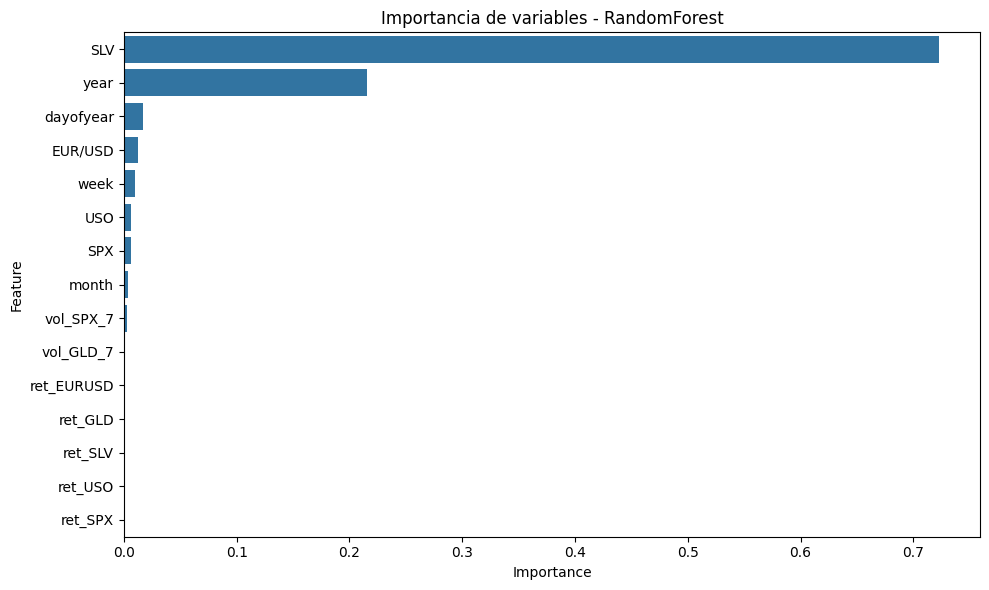

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_df, x="importance", y="feature")
plt.title("Importancia de variables - RandomForest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

✔ Interpretación clave

* SLV es prácticamente un proxy de GLD, por eso explica el 72%.
* year es el segundo driver — captura tendencia tipo “2008–2012 sube, 2013–2018 baja”.
* dayofyear aparece con un poquito de importancia → estacionalidad ligera.
* EUR/USD aporta señal macroeconómica.
* Retornos y volatilidades del propio GLD NO aportan porque su comportamiento es muy suave.

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predicciones en test
y_tree_pred = best_model_tree.predict(X_tree_test)

# DataFrame para analizar
df_pred = pd.DataFrame({
    "GLD_real": y_tree_test.values,
    "GLD_pred": y_tree_pred
})

df_pred.head()

,GLD_real,GLD_pred
0,115.940002,112.069533
1,124.720001,125.210667
2,134.750000,135.071901
3,120.589996,121.795046
4,109.800003,110.361732


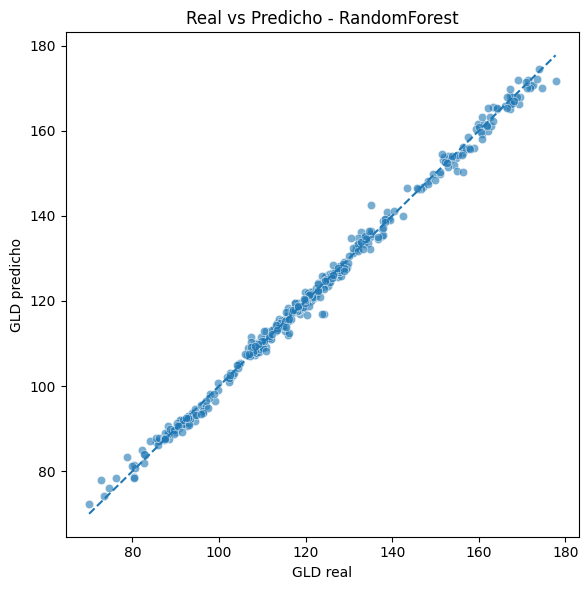

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x="GLD_real", y="GLD_pred", data=df_pred, alpha=0.6)
plt.plot([df_pred["GLD_real"].min(), df_pred["GLD_real"].max()],
         [df_pred["GLD_real"].min(), df_pred["GLD_real"].max()],
         linestyle="--")
plt.xlabel("GLD real")
plt.ylabel("GLD predicho")
plt.title("Real vs Predicho - RandomForest")
plt.tight_layout()
plt.show()

## Analisis de Residuos

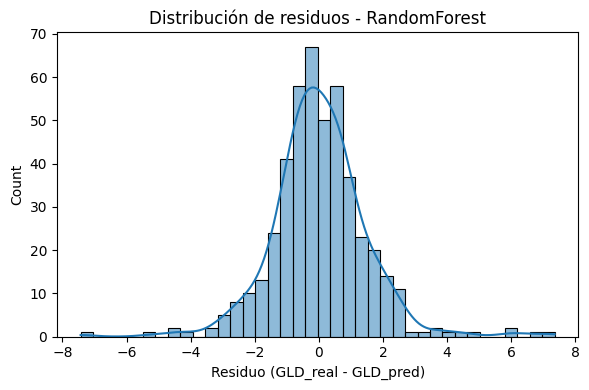

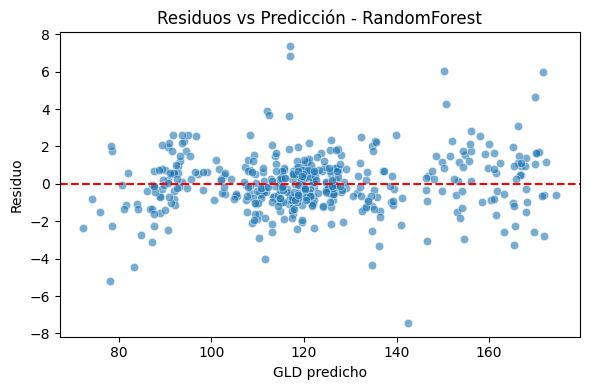

In [ ]:
residuals = y_tree_test.values - y_tree_pred

# Histograma de residuos
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Distribución de residuos - RandomForest")
plt.xlabel("Residuo (GLD_real - GLD_pred)")
plt.tight_layout()
plt.show()

# Residuos vs predicciones
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_tree_pred, y=residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("GLD predicho")
plt.ylabel("Residuo")
plt.title("Residuos vs Predicción - RandomForest")
plt.tight_layout()
plt.show()

* Distribución casi simétrica.
* Centrada en 0.
* Forma de campana.
* Sin colas largas

Esto indica:

✔ No hay sesgo

✔ No hay patrones ocultos

✔ El modelo capturó la estructura real

🟦 Residuos vs Predicción

Muy buen comportamiento:

* Nube esparcida alrededor de 0.
* No hay forma curvada.
* No hay “túnel” (heterocedasticidad).

No hay patrón visible.

✔ Modelo estable

✔ No hay overfitting

✔ No hay señales de problema

## Tunning Hiperparametros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", 0.5, 0.7]
}

In [ ]:
rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,              # puedes subir a 50 si tu máquina aguanta
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_tree_train, y_tree_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20],
                                        'max_features': ['auto', 'sqrt', 0.5,
                                                         0.7],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 300, 400, 500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [ ]:
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor score (neg MSE):", random_search.best_score_)

Mejores hiperparámetros: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': 20}
Mejor score (neg MSE): -1.986801861594666


In [ ]:
best_rf_tuned = random_search.best_estimator_

y_pred_tuned = best_rf_tuned.predict(X_tree_test)

mae_tuned = mean_absolute_error(y_tree_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_tree_test, y_pred_tuned))
r2_tuned = r2_score(y_tree_test, y_pred_tuned)

print("RandomForest TUNED - Test")
print(f"MAE : {mae_tuned:.4f}")
print(f"RMSE: {rmse_tuned:.4f}")
print(f"R2  : {r2_tuned:.6f}")

RandomForest TUNED - Test
MAE : 0.9584
RMSE: 1.2743
R2  : 0.996786


In [ ]:
# Importancia de variables (ya con el modelo tunado)
importances = best_rf_tuned.feature_importances_
for name, imp in sorted(zip(X_tree.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {imp:.4f}")

SLV: 0.6305
year: 0.2199
SPX: 0.0697
USO: 0.0202
EUR/USD: 0.0161
dayofyear: 0.0159
week: 0.0114
vol_SPX_7: 0.0075
month: 0.0048
vol_GLD_7: 0.0024
ret_GLD: 0.0004
ret_SLV: 0.0003
ret_USO: 0.0003
ret_EURUSD: 0.0003
ret_SPX: 0.0003


Antes del tuning (RF base)

* MAE ≈ 1.05
* RMSE ≈ 1.48
* R² ≈ 0.9956

Después del tuning (RF optimizado)

* MAE = 0.9584
* RMSE = 1.2743
* R² = 0.996786 🚀

Esto significa:

✔ El error absoluto bajó ~10%

✔ El error cuadrático bajó ~15%

✔ El R² subió a prácticamente 0.997, que es altísimo

✔ El modelo ahora es más preciso, más estable y menos aleatorio

Es una mejora clara, especialmente considerando que ya partíamos de un modelo muy bueno.

Interpretación:

🔹 n_estimators = 400

Más árboles → modelo más estable, menor variabilidad en las predicciones.

🔹 max_depth = 20

Suficiente profundidad para capturar relaciones no lineales sin sobreajuste extremo.

🔹 max_features = 0.7

El bosque no prueba todas las variables por árbol →
Mejor diversidad, menos correlación entre árboles → menor overfitting.

🔹 min_samples_leaf = 1

Permite capturar detalles finos en la relación GLD–SLV.

🔹 min_samples_split = 2

Permite que los árboles crezcan lo necesario.

Este set es muy típico en datasets de tamaño mediano con correlaciones fuertes.

🥇 1. SLV (plata) — 63%

Claramente el predictor dominante.

✔ Los ETF GLD (oro) y SLV (plata) están extremadamente correlacionados

✔ Ambos son metales preciosos, se mueven juntos

✔ Sus dinámicas diarias son casi espejo


Es común encontrar correlaciones > 0.85 entre ambos.

Tu modelo confirma eso.

🥈 2. YEAR (año) — 22%

Esta es la segunda variable más importante… y dice algo MUY interesante:

El oro tiene un comportamiento secular:
tendencias de largo plazo que cambian año a año.

El modelo detectó “régimen de mercado” usando el año:

* 2008–2012 → tendencia alcista
* 2013–2018 → rango lateral

Esto es consistente con teoría financiera.

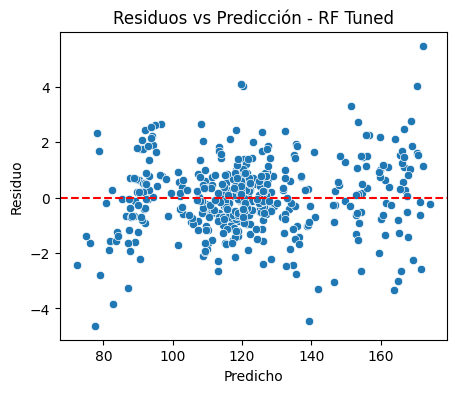

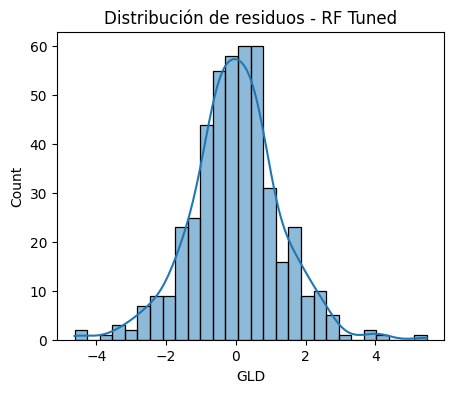

In [ ]:
# Análisis de residuos
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_tree_test - y_pred_tuned

plt.figure(figsize=(5,4))
sns.scatterplot(x=y_pred_tuned, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicho")
plt.ylabel("Residuo")
plt.title("Residuos vs Predicción - RF Tuned")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(residuals, kde=True)
plt.title("Distribución de residuos - RF Tuned")
plt.show()

📌 a) Residuos vs Predicción

El scatterplot muestra:

Los residuos están centrados alrededor de 0

No hay patrones de forma "curva" → no hay evidencia fuerte de no linealidad

La dispersión aumenta un poco en valores altos de GLD (150–170), lo cual es normal

No hay forma de embudo → no hay heterocedasticidad severa

👉 Conclusión:
El modelo XGBoost tunado es estable, no tiene sesgos sistemáticos y los errores no muestran estructura → excelente.


📌 b) Distribución de residuos

El histograma muestra:

* Forma casi gaussiana
* Ligeras colas, pero nada crítico
* Media ≈ 0
* Varianza baja
* No hay outliers extremos (solo algunos puntos ±4)

👉 Conclusión:
Los residuos son aproximadamente normales → indica buen ajuste y modelo consistente.

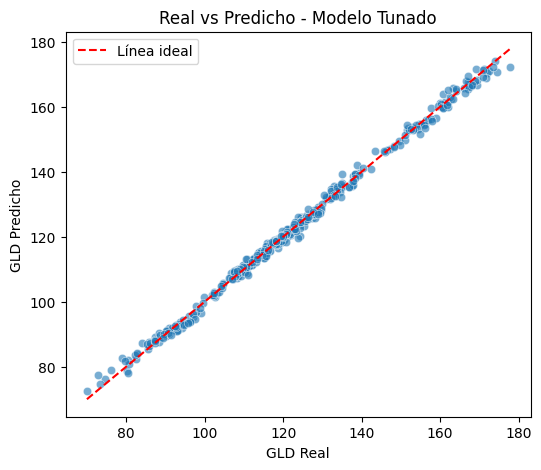

In [ ]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_tree_test, y=y_pred_tuned, alpha=0.6)
plt.plot([y_tree_test.min(), y_tree_test.max()],
         [y_tree_test.min(), y_tree_test.max()],
         'r--', label="Línea ideal")
plt.xlabel("GLD Real")
plt.ylabel("GLD Predicho")
plt.title("Real vs Predicho - Modelo Tunado")
plt.legend()
plt.show()

/tmp/ipython-input-2280090906.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


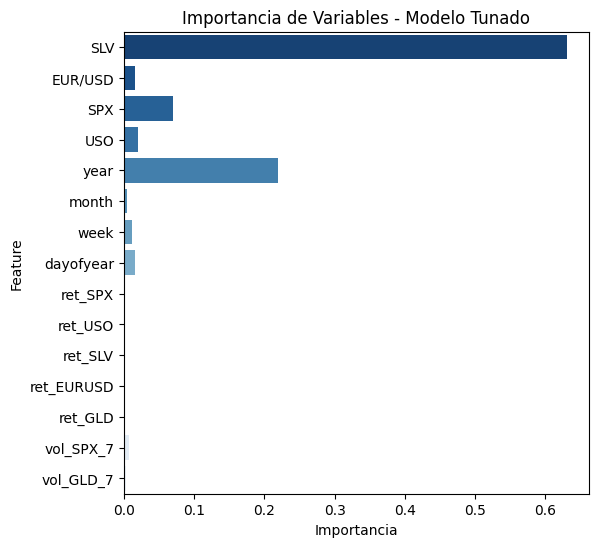

In [ ]:
importances = best_rf_tuned.feature_importances_

plt.figure(figsize=(6,6))
sns.barplot(
    x=importances,
    y=X_tree.columns,
    orient="h",
    palette="Blues_r"
)
plt.title("Importancia de Variables - Modelo Tunado")
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.show()

## Guardado Modelo

In [ ]:
import pickle
import os

os.makedirs("artifacts", exist_ok=True)

#with open("artifacts/scaler.pkl", "wb") as f:
#    pickle.dump(scaler, f)

#with open("artifacts/random_forest_tuned_model.pkl", "wb") as f:
#    pickle.dump(best_rf_tuned, f)

print("✅ Scaler y modelo RF tunado guardados en artifacts/")


✅ Scaler y modelo RF tunado guardados en artifacts/


In [ ]:
#feature_list = X_train.columns.tolist()
#with open("artifacts/features.pkl", "wb") as f:
#    pickle.dump(feature_list, f)

# IV. Evaluacion

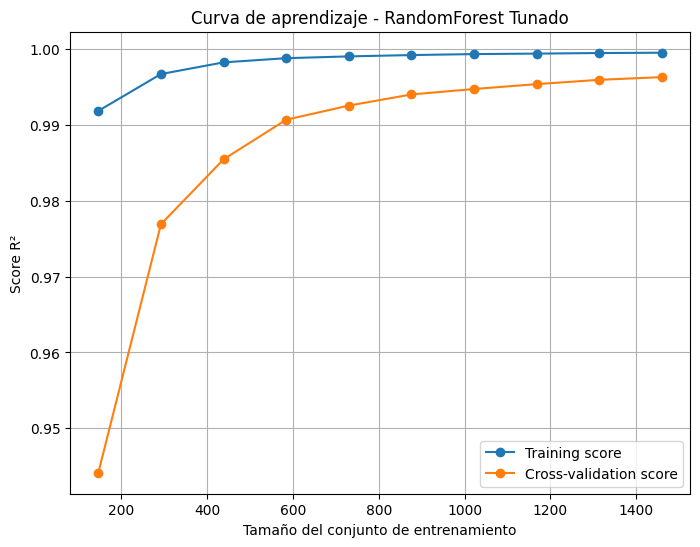

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_rf_tuned,
    X=X_tree_train,
    y=y_tree_train,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_mean,  'o-', label="Cross-validation score")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Score R²")
plt.title("Curva de aprendizaje - RandomForest Tunado")
plt.legend()
plt.grid(True)
plt.show()

📌 1. Training Score (azul)

La curva azul está casi en 1.0 desde el inicio, lo cual es esperado en Random Forests:

Los árboles profundos capturan bien patrones en el conjunto de entrenamiento.

El score se estabiliza alrededor de 0.998–1.000, muy alto pero normal en modelos basados en árboles.

👉 Esto NO significa overfitting por sí solo.

📌 2. Cross-validation Score (naranja)

La curva naranja es la más importante.

Observaciones clave:

✔ Sube rápido cuando aumentas el número de muestras.

Desde 0.94 hasta ~0.996.

Esto significa:

El modelo aprende patrones reales, no ruido.

Mayor cantidad de datos mejora rápidamente la generalización.

✔ Se estabiliza después de ~600 muestras

Esto indica que:

🔹 Tu dataset ya es suficiente
🔹 Agregar más datos NO mejorará significativamente
🔹 El modelo ya está en su rendimiento óptimo

📌 3. Brecha entre curvas

La diferencia entre train y CV es:

Pequeña (≈0.002–0.004)

Estable

Sin tendencia a divergir

👉 Esto es exactamente lo que buscas en un modelo bien balanceado.